In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_colwidth', 200)

In [2]:
data = pd.read_pickle('/content/drive/MyDrive/Sentiment_analysis_tweets/Data/cleaned_tweets_1.pkl')
data.head()

,id,label,tweet,cleaned_tweets,cleaned_tweets_with_stopwords
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone,fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,finally a transparant silicon case thanks to my uncle yay sony xperia s sonyexperias,finally transparant silicon case thanks uncle yay sony xperia sonyexperias
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,we love this would you go talk makememories unplug relax iphone smartphone wifi connect,love talk makememories unplug relax iphone smartphone wifi connect
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,i am wired i know i am george i wa made that way iphone cute daventry home,wired know george way iphone cute daventry home
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,what amazing service apple will not even talk to me about a question i have unless i pay them for their stupid support,amazing service apple talk question unless pay stupid support


In [3]:
import tensorflow

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import pydot
import keras.backend as k

In [4]:
def define_model(n_words):
    model = Sequential()

    model.add(Input(shape=(n_words,)))
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))

    model.add(Dense(32, activation='relu', kernel_regularizer='l2'))

    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.summary()
    return model

In [5]:
def evaluate_model(X_train,y_train,X_test,y_test):
  scores = list()
  n_repeats = 5
  n_words = X_test.shape[1]

  for i in range(n_repeats):

    model = define_model(n_words)

    model.fit(X_train,y_train, epochs=10, verbose=0)

    _, acc = model.evaluate(X_test, y_test, verbose=0)

    scores.append(acc)
    print('%d accuracy: %s' % ((i + 1), acc))
  return scores

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [7]:
train_docs = data['cleaned_tweets_with_stopwords']
tokenizer = create_tokenizer(train_docs)

In [8]:
X = tokenizer.texts_to_matrix(train_docs, mode='binary')

In [9]:
X.shape

(7920, 16270)

In [10]:
X[0]

array([0., 1., 0., ..., 0., 0., 0.])

In [11]:
y = data['label']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [13]:
X_train.shape, X_test.shape

((6336, 16270), (1584, 16270))

In [14]:
k.clear_session()
n_words = X_train.shape[1]
model = define_model(n_words)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │       1,041,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,043,457 (3.98 MB)

 Trainable params: 1,043,457 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',)

model.fit(X_train,y_train,epochs = 50, callbacks = [early_stop],verbose=2, batch_size=128, validation_data=(X_test,y_test))

Epoch 1/50
50/50 - 4s - 87ms/step - accuracy: 0.7555 - loss: 1.0621 - val_accuracy: 0.8062 - val_loss: 0.7200
Epoch 2/50
50/50 - 4s - 82ms/step - accuracy: 0.8527 - loss: 0.6257 - val_accuracy: 0.8655 - val_loss: 0.5658
Epoch 3/50
50/50 - 2s - 33ms/step - accuracy: 0.8734 - loss: 0.5157 - val_accuracy: 0.8687 - val_loss: 0.4892
Epoch 4/50
50/50 - 3s - 50ms/step - accuracy: 0.8824 - loss: 0.4562 - val_accuracy: 0.8731 - val_loss: 0.4481
Epoch 5/50
50/50 - 2s - 33ms/step - accuracy: 0.8851 - loss: 0.4216 - val_accuracy: 0.8813 - val_loss: 0.4222
Epoch 6/50
50/50 - 3s - 66ms/step - accuracy: 0.8906 - loss: 0.4018 - val_accuracy: 0.8857 - val_loss: 0.4101
Epoch 7/50
50/50 - 3s - 58ms/step - accuracy: 0.8946 - loss: 0.3878 - val_accuracy: 0.8838 - val_loss: 0.4031
Epoch 8/50
50/50 - 4s - 86ms/step - accuracy: 0.9006 - loss: 0.3773 - val_accuracy: 0.8794 - val_loss: 0.4010
Epoch 9/50
50/50 - 2s - 47ms/step - accuracy: 0.9020 - loss: 0.3693 - val_accuracy: 0.8845 - val_loss: 0.3892
Epoch 10/5

In [16]:
df = pd.DataFrame(model.history.history)

In [17]:
df

,accuracy,loss,val_accuracy,val_loss
0,0.755524,1.062053,0.806187,0.719985
1,0.852746,0.625651,0.865530,0.565818
2,0.873422,0.515691,0.868687,0.489199
3,0.882418,0.456241,0.873106,0.448121
4,0.885101,0.421571,0.881313,0.422188
5,0.890625,0.401758,0.885732,0.410116
6,0.894571,0.387794,0.883838,0.403101
7,0.900568,0.377274,0.879419,0.400983
8,0.901989,0.369303,0.884470,0.389179
9,0.906723,0.359689,0.883838,0.389078


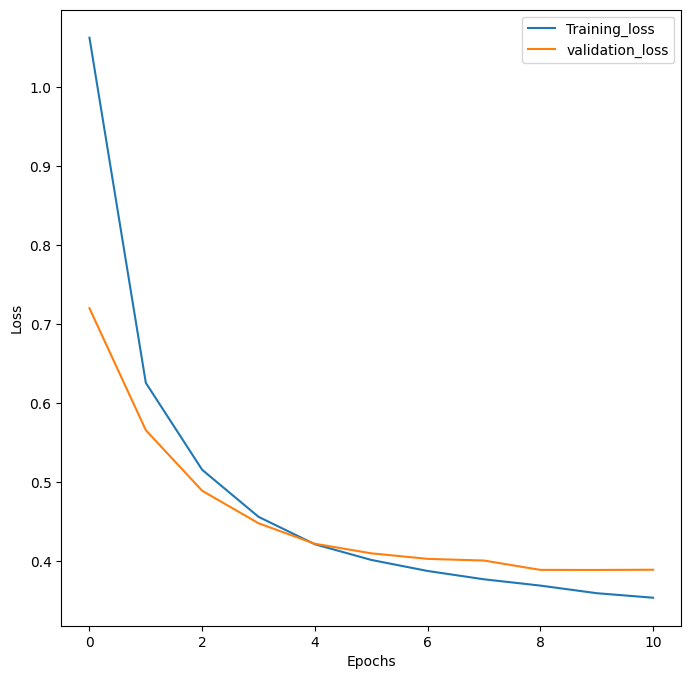

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.plot(df['loss'], label='Training_loss')
plt.plot(df['val_loss'], label='validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

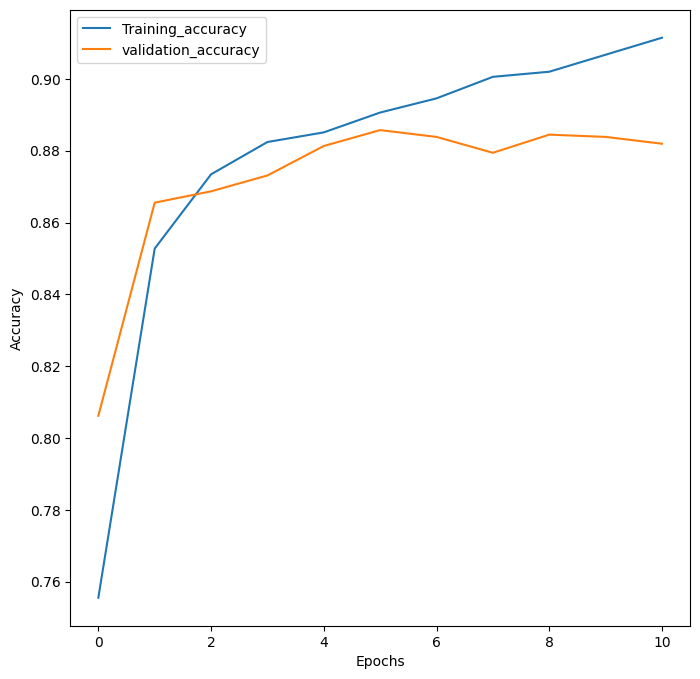

In [19]:
plt.figure(figsize=(8,8))

plt.plot(df['accuracy'], label='Training_accuracy')
plt.plot(df['val_accuracy'], label='validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [21]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 88.194442


In [22]:
res = evaluate_model(X_train,y_train,X_test,y_test)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │       1,041,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,043,457 (3.98 MB)

 Trainable params: 1,043,457 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

1 accuracy: 0.8888888955116272


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 64)                  │       1,041,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,043,457 (3.98 MB)

 Trainable params: 1,043,457 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

2 accuracy: 0.8901515007019043


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 64)                  │       1,041,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,043,457 (3.98 MB)

 Trainable params: 1,043,457 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

3 accuracy: 0.9021464586257935


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 64)                  │       1,041,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,043,457 (3.98 MB)

 Trainable params: 1,043,457 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

4 accuracy: 0.8844696879386902


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 64)                  │       1,041,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,043,457 (3.98 MB)

 Trainable params: 1,043,457 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

5 accuracy: 0.8882575631141663


In [23]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout

In [24]:
data.head()

,id,label,tweet,cleaned_tweets,cleaned_tweets_with_stopwords
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone,fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,finally a transparant silicon case thanks to my uncle yay sony xperia s sonyexperias,finally transparant silicon case thanks uncle yay sony xperia sonyexperias
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,we love this would you go talk makememories unplug relax iphone smartphone wifi connect,love talk makememories unplug relax iphone smartphone wifi connect
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,i am wired i know i am george i wa made that way iphone cute daventry home,wired know george way iphone cute daventry home
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,what amazing service apple will not even talk to me about a question i have unless i pay them for their stupid support,amazing service apple talk question unless pay stupid support


In [25]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_tweets_with_stopwords'],data['label'], test_size=0.2, random_state=42)

In [26]:
X_train.shape

(6336,)

In [27]:
def encode_docs(tokenizer, max_length, docs):

  encoded = tokenizer.texts_to_sequences(docs)

  padded = pad_sequences(encoded, maxlen=max_length, padding='post')
  return padded

In [30]:
vocab_size = len(tokenizer.word_index) + 1
print('vocabulary size: %d' % vocab_size)

max_length = max([len(s.split()) for s in train_docs])
print("Maximum length: %d" % max_length)

vocabulary size: 13999
Maximum length: 37


In [31]:
tokenizer = create_tokenizer(X_train)
padded_docs_train = encode_docs(tokenizer, max_length, X_train)
padded_docs_train

array([[   71,   246,  4597, ...,     0,     0,     0],
       [   18,    36,     8, ...,     0,     0,     0],
       [  746,  1282,  2941, ...,     0,     0,     0],
       ...,
       [   56,   136,    66, ...,     0,     0,     0],
       [   18, 13996,     1, ...,     0,     0,     0],
       [   26,     1,  1444, ...,     0,     0,     0]], dtype=int32)

In [32]:
padded_docs_train.shape

(6336, 37)

In [33]:
tokenizer = create_tokenizer(X_test)
padded_docs_test = encode_docs(tokenizer, max_length, X_test)
padded_docs_test.shape

(1584, 37)

In [37]:
def define_model(vocab_size, max_length):

  model = Sequential()
  model.add(Input(shape=(max_length,)))
  model.add(Embedding(vocab_size, 300))

  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Conv1D(filters=64, kernel_size=8, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))

  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [38]:
k.clear_session()
model = define_model(vocab_size, max_length)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 37, 300)             │       4,199,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 35, 64)              │          57,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 10, 64)              │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,312,853 (16.45 MB)

 Trainable params: 4,312,853 (16.45 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# fit network
model.fit(padded_docs_train, y_train, epochs=25, verbose=2, validation_data=(padded_docs_test, y_test))

# save the model
model.save('model_DL_WE.h5')

Epoch 1/25
198/198 - 15s - 74ms/step - accuracy: 0.8272 - loss: 0.3622 - val_accuracy: 0.7431 - val_loss: 0.6874
Epoch 2/25
198/198 - 11s - 56ms/step - accuracy: 0.9306 - loss: 0.1741 - val_accuracy: 0.7330 - val_loss: 0.8137
Epoch 3/25
198/198 - 10s - 50ms/step - accuracy: 0.9724 - loss: 0.0827 - val_accuracy: 0.7247 - val_loss: 1.4890
Epoch 4/25
198/198 - 12s - 59ms/step - accuracy: 0.9853 - loss: 0.0453 - val_accuracy: 0.7241 - val_loss: 2.3913
Epoch 5/25
198/198 - 20s - 99ms/step - accuracy: 0.9901 - loss: 0.0299 - val_accuracy: 0.7235 - val_loss: 2.1275
Epoch 6/25
198/198 - 21s - 108ms/step - accuracy: 0.9951 - loss: 0.0131 - val_accuracy: 0.7077 - val_loss: 2.3699
Epoch 7/25
198/198 - 19s - 94ms/step - accuracy: 0.9975 - loss: 0.0069 - val_accuracy: 0.7134 - val_loss: 2.9764
Epoch 8/25
198/198 - 12s - 59ms/step - accuracy: 0.9978 - loss: 0.0054 - val_accuracy: 0.7052 - val_loss: 3.2204
Epoch 9/25
198/198 - 12s - 59ms/step - accuracy: 0.9970 - loss: 0.0070 - val_accuracy: 0.6780 -

In [42]:
# evaluate the model ONCe on the test set
loss, acc = model.evaluate(padded_docs_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 68.308079
